# Shifting MNIST dataset

In [1]:
import os
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from augly import image
from multiprocessing import Pool

from sklearn.decomposition import PCA

In [2]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [3]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

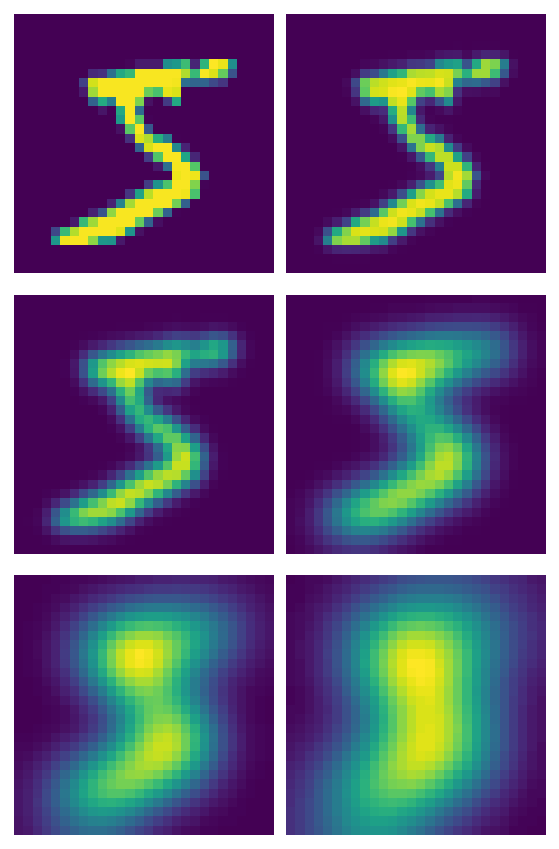

In [5]:
radii = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0]
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(3, 2, figsize=(4, 6))
for axi, radius in zip(ax.flat, radii):
    x_shift = image.aug_np_wrapper(X_train[0], image.blur, radius=radius)
    axi.imshow(x_shift)
    axi.axis("off")
plt.tight_layout()

In [6]:
class BlurRad:
    def __init__(self, rad):
        self.rad = rad
        
    def __call__(self, img):
        return self.blur_multiple(img)

    def blur(self, X):
        """
        Blur an image using the augly library

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        radius: float
            The amout of blurriness
        """
        return image.aug_np_wrapper(X, image.blur, radius=self.rad)

    def blur_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_blur = self.blur(X)
            images_out.append(img_blur)
        images_out = np.stack(images_out, axis=0)
        return images_out

## Estimating weights

In [8]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn # Assuming top-level funciton is jitted
    # return jax.jit(loss_fn) # assuming top-level function is not jitted


class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

    
def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step


def proc_dataset(radius, img_dataset, n_processes=90):
    """
    Blur all images of a dataset stored in a numpy array.
    
    Parameters
    ----------
    radius: float
        Intensity of bluriness
    img_dataset: array(N, L, K)
        N images of size LxK
    n_processes: int
        Number of processes to blur over
    """
    pool = Pool(processes=n_processes)
    
    dataset_proc = np.array_split(img_dataset, n_processes)
    dataset_proc = pool.map(BlurRad(radius), dataset_proc)
    dataset_proc = np.concatenate(dataset_proc, axis=0)
    
    pool.close()
    
    return dataset_proc

In [9]:
key = jax.random.PRNGKey(314)

alpha = 0.001
n_classes = 10
n_subset = 5000
batch_size = 2_000
n_epochs = 150
tx = optax.adam(learning_rate=alpha)

model = MLPWide(n_classes)
# X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
# y_train_ohe = jax.nn.one_hot(y_train, n_classes)


def train_model_config(key, radius, num_epochs):
    X_train_proc = proc_dataset(radius, X_train, 90)
    X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
    y_train_ohe = jax.nn.one_hot(y_train, n_classes)

    batch = jnp.ones((1, 28 ** 2))
    params = model.init(key, batch)
    opt_state = tx.init(params)

    for e in range(num_epochs):
        print(f"@epoch {e+1:03}", end="\r")
        _, key = jax.random.split(key)
        params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

    final_train_acc = (y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean().item()
    print(f"@{rad=:0.4f}, {final_train_acc=:0.4f}")
    
    return params, final_train_acc

In [ ]:
hist_params = []
hist_accuracy = []
radii = jnp.linspace(0.001, 3.00, 100)

time_start = time()
for rad in radii:
    params, train_acc = train_model_config(key, rad, n_epochs)
    
    hist_accuracy.append(train_acc)
    hist_params.append(params)

hist_accuracy = jnp.array(hist_accuracy)
time_end = time()
time_total = time_end - time_start
print(f"Total running time: {time_total:0.2f}s")

In [14]:
filename = "mnist_shift_params.npy"

if os.path.exists(filename):
    hist_params_flat = jnp.load(filename)
else:
    hist_params_flat = dojax.flat_and_concat_params(hist_params)
    jnp.save(filename, hist_params_flat)

In [18]:
hist_params_flat.shape

(100, 1033510)

In [20]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(hist_params_flat)

In [24]:
params_proj.shape

(100, 2)

(-18.66602964401245,
 19.561443996429443,
 -15.191810512542725,
 21.78753843307495)

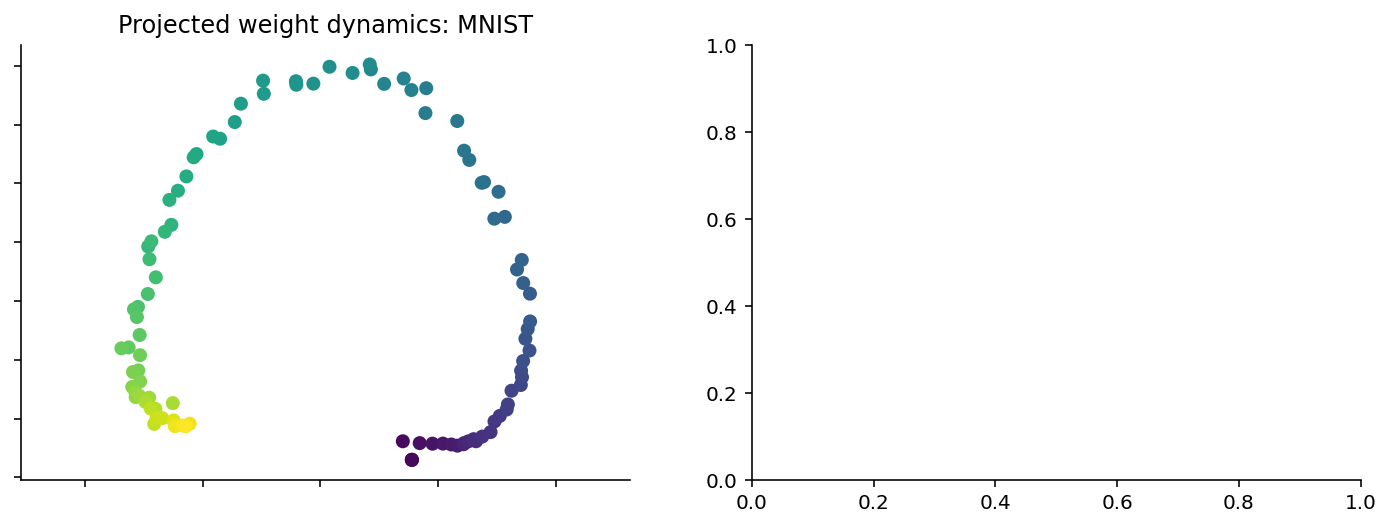

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=radii)
# ax[0].cb(label="radius")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")

ax[1].set_title("Accuracy")
ax[1].scatter(radii, hist_accuracy, c=radii)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy")

In [30]:
pca = PCA(n_components=3)
params_proj = pca.fit_transform(hist_params_flat)

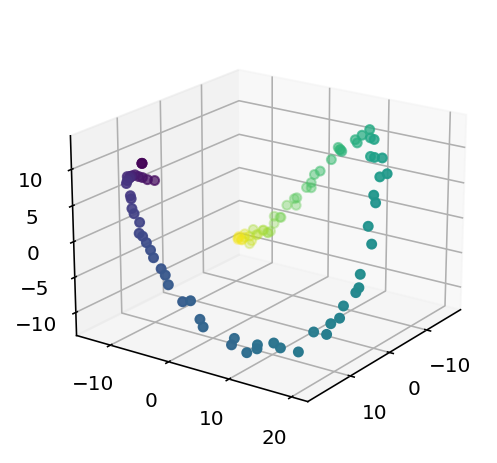

In [40]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.view_init(20, 35)
ax.scatter(*params_proj.T, c=radii)

## Modelling weight dynamics

In [51]:
class MLPWeights(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(200)(x))
        x = nn.Dense(self.num_outputs)(x)
        return x


In [43]:
pca = PCA(n_components=60)
params_proj = pca.fit_transform(hist_params_flat)

In [44]:
params_proj.shape

(100, 60)

In [52]:
X_train

(60000, 28, 28)

### Steps to follow
1. Modify `proc_dataset` so that it takes as input a list of radii and images. Both elements should have the same cardinality over the leading dimension. Its output is a list of weights
2. Modify `make_loss_fn` so that it considers an output in R^d (d-dimensional output with real-valued entries)
3. Modify `get_batch_train_ixs` so that it takes `num_samples` and `num_configs`, where `num_configs` is the total number of configuration. To do this, create a `num_samples x num_configs` count array. Then, given an index `i`, we obtain its config as `i % num_configs`; we obtain its config in the database as `i / num_configs`. Consider the following example:

In [67]:
num_samples = 10
num_configs = 3

samples_ix = jnp.arange(num_samples * num_configs)

In [86]:
# Choose configuration
samples_ix.reshape(num_samples, num_configs) % num_configs

DeviceArray([[0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2],
             [0, 1, 2]], dtype=int32)

In [87]:
# Choose index
samples_ix.reshape(num_samples, num_configs) // num_configs

DeviceArray([[0, 0, 0],
             [1, 1, 1],
             [2, 2, 2],
             [3, 3, 3],
             [4, 4, 4],
             [5, 5, 5],
             [6, 6, 6],
             [7, 7, 7],
             [8, 8, 8],
             [9, 9, 9]], dtype=int32)

In [90]:
samples_ix[14] // num_configs

DeviceArray(4, dtype=int32)

In [89]:
samples_ix[14] % num_configs

DeviceArray(2, dtype=int32)

4. Modify `train_epoch` so that it samples from the indices defined in `3.`. Then, it should return a list of indices to train and radii to try. We modify the input X with the list of radii and obtain our target variable (the weights to predict) given by the list of radii. We then call the modified version of `train_step` with the batch as big as possible (so as to minimise the overhead of computing the transformations of `X`)

5. Modify `train_step` so that it considers the new `make_loss_fn` defined in step `2.`

### Implementation

In [93]:
...

Ellipsis